<a href="https://colab.research.google.com/github/shyamkumaran/ExplainableAI_SHAP/blob/main/XAI_RSNA_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 14.7 MB/s 


In [ ]:
import shap
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2

In [ ]:
tf.__version__

'2.9.2'

In [ ]:
# confirm gpu is used
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
import pandas as pd
df_rsna = pd.read_csv('/content/drive/MyDrive/OD_RSNA/train_bak.csv')
df_rsna.head(4)

,Unnamed: 0,FileName,XMin,XMax,YMin,YMax,ClassName
0,0,000924cf-0f8d-42bd-9158-1af53881a557.png,0.0,0.0,0.0,0.0,Normal
1,1,000db696-cf54-4385-b10b-6b16fbb3f985.png,316.0,486.0,318.0,796.0,Lung Opacity
2,2,000db696-cf54-4385-b10b-6b16fbb3f985.png,316.0,486.0,318.0,796.0,Lung Opacity
3,3,000db696-cf54-4385-b10b-6b16fbb3f985.png,660.0,806.0,375.0,777.0,Lung Opacity


In [ ]:
df_rsna.rename(columns = {'FileName':'filename', 'ClassName':'class','XMin':'xmin','XMax':'xmax','YMin':'ymin','YMax':'ymax'}, inplace = True)

In [ ]:
#Use Label encoder available in Scikit Learn
from sklearn import preprocessing
#Label Encode class and add a 'label' column to the dataframe
le = preprocessing.LabelEncoder()
df_rsna['label'] = le.fit_transform(df_rsna['class'])
df_rsna.head(4)

,Unnamed: 0,filename,xmin,xmax,ymin,ymax,class,label
0,0,000924cf-0f8d-42bd-9158-1af53881a557.png,0.0,0.0,0.0,0.0,Normal,1
1,1,000db696-cf54-4385-b10b-6b16fbb3f985.png,316.0,486.0,318.0,796.0,Lung Opacity,0
2,2,000db696-cf54-4385-b10b-6b16fbb3f985.png,316.0,486.0,318.0,796.0,Lung Opacity,0
3,3,000db696-cf54-4385-b10b-6b16fbb3f985.png,660.0,806.0,375.0,777.0,Lung Opacity,0


In [ ]:
# build lists with filenames present in the train folder

import os
dir_path_train = '/content/drive/MyDrive/OD_RSNA/images/train'
list_of_images_in_train_dir = []
i=0
for file in os.listdir(dir_path_train):
     # check the files which end with .png extension
    if file.endswith(".png"):
      list_of_images_in_train_dir.append(file)

df_imgs_in_train = pd.DataFrame(list_of_images_in_train_dir)

df_train_folder_imgs = df_rsna[df_rsna['filename'].isin(df_imgs_in_train[0])]

df_train_folder_imgs.head(10)

,Unnamed: 0,filename,xmin,xmax,ymin,ymax,class,label
0,0,000924cf-0f8d-42bd-9158-1af53881a557.png,0.0,0.0,0.0,0.0,Normal,1
1,1,000db696-cf54-4385-b10b-6b16fbb3f985.png,316.0,486.0,318.0,796.0,Lung Opacity,0
2,2,000db696-cf54-4385-b10b-6b16fbb3f985.png,316.0,486.0,318.0,796.0,Lung Opacity,0
3,3,000db696-cf54-4385-b10b-6b16fbb3f985.png,660.0,806.0,375.0,777.0,Lung Opacity,0
4,4,000db696-cf54-4385-b10b-6b16fbb3f985.png,660.0,806.0,375.0,777.0,Lung Opacity,0
5,5,000fe35a-2649-43d4-b027-e67796d412e0.png,570.0,839.0,282.0,691.0,Lung Opacity,0
6,6,000fe35a-2649-43d4-b027-e67796d412e0.png,570.0,839.0,282.0,691.0,Lung Opacity,0
7,7,000fe35a-2649-43d4-b027-e67796d412e0.png,83.0,379.0,227.0,665.0,Lung Opacity,0
8,8,000fe35a-2649-43d4-b027-e67796d412e0.png,83.0,379.0,227.0,665.0,Lung Opacity,0
9,9,001031d9-f904-4a23-b3e5-2c088acd19c6.png,66.0,439.0,160.0,768.0,Lung Opacity,0


In [ ]:
## Just taking 200 samples from the dataset
sample_trainingdata = df_train_folder_imgs.groupby('class', group_keys=False).apply(lambda x: x.sample(100))

In [ ]:
sample_trainingdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 12055 to 19389
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  200 non-null    int64  
 1   filename    200 non-null    object 
 2   xmin        200 non-null    float64
 3   xmax        200 non-null    float64
 4   ymin        200 non-null    float64
 5   ymax        200 non-null    float64
 6   class       200 non-null    object 
 7   label       200 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 14.1+ KB


In [ ]:
## Checking the training data set with class distbution
sample_trainingdata["class"].value_counts()
#df_train_folder_imgs['class'].value_counts()

Lung Opacity    100
Normal          100
Name: class, dtype: int64

In [ ]:
## Pre Processing the image
from tensorflow.keras.applications.mobilenet import preprocess_input
import skimage.io as io

images = []
ADJUSTED_IMAGE_SIZE = 128
#ADJUSTED_IMAGE_SIZE = 28
imageList = []
classLabels = []
labels = []
originalImage = []
# Function to read the image from the path and reshape the image to size
def readAndReshapeImage(image):
    img = np.array(image).astype(np.uint8)
    ## Resize the image
    res = cv2.resize(img,(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    return res

## Read the imahge and resize the image
def populateImage(rowData):
    for index, row in rowData.iterrows():
        patientId = row.filename
        #classlabel = row["class"]
        classlabel = row["label"]

        img_file = '/content/drive/MyDrive/OD_RSNA/images/train/'+'{}'.format(patientId)
        img = io.imread(img_file)


        ## Converting the image to 3 channels as the dicom image pixel does not have colour classes with it
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, -1)

        imageList.append(readAndReshapeImage(img))

#         originalImage.append(img)
        classLabels.append(classlabel)

    tmpImages = np.array(imageList)
    tmpLabels = np.array(classLabels)

#     originalImages = np.array(originalImage)
    return tmpImages,tmpLabels

In [ ]:
## Reading the images into numpy array
images,labels = populateImage(sample_trainingdata)
#images,labels = populateImage(df_train_folder_imgs)

In [ ]:
images.shape , labels.shape
## The image is of 128*128 with 3 channels
#images = images.reshape(1600,28,28,1)
#(1600, 28, 28, 1)

((200, 128, 128, 3), (200,))

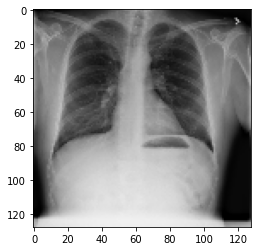

In [ ]:
## Checking one of the converted image
#img_add_dim = np.expand_dims(images[100], axis=3)
#img_add_dim = images[100].reshape(28,28)
plt.imshow(images[100])
#plt.imshow(img_add_dim,cmap='gray')

In [ ]:
## encoding the labels
from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()

y2 = enc.fit_transform(labels)

In [ ]:
## splitting into train ,test and validation data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, y2, test_size=0.3, random_state=50)
#X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=50)

In [ ]:
## FUnction to create a dataframe for results
def createResultDf(name,accuracy,testscore):
    result = pd.DataFrame({'Method':[name], 'accuracy': [accuracy] ,'Test Score':[testscore]})
    return result

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train1 = to_categorical(y_train, num_classes=2)
y_test1 = to_categorical(y_test, num_classes=2)

print("Shape of y_train:", y_train.shape)
print("One value of y_train:", y_train[0])

Shape of y_train: (140, 1)
One value of y_train: [1]


In [ ]:
from keras.models import Sequential  # initial NN
from keras.layers import Dense, Dropout # construct each layer
from keras.layers import Conv2D # swipe across the image by 1
from keras.layers import MaxPooling2D # swipe across by pool size
from keras.layers import Flatten, GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(128, 128,3)))
model.add(Conv2D(filters=32, kernel_size=3, activation="relu"))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(2, activation="sigmoid"))

In [ ]:
model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")

# Use earlystopping
#callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, min_delta=0.01)

# Fit the model
model.fit(x=X_train, y=y_train1, batch_size=32, epochs=3, validation_split = 0.3)

# Fit the model
#model.fit( x=X_train, y=y_train1, batch_size=30, epochs=5, validation_split = 0.3, callbacks=[callback])

Epoch 1/3
4/4 [==============================] - 8s 144ms/step - loss: 3466.7966 - accuracy: 0.5204 - val_loss: 836.1650 - val_accuracy: 0.5000
Epoch 2/3
4/4 [==============================] - 0s 41ms/step - loss: 688.9567 - accuracy: 0.4184 - val_loss: 231.4609 - val_accuracy: 0.5000
Epoch 3/3
4/4 [==============================] - 0s 40ms/step - loss: 98.7197 - accuracy: 0.5612 - val_loss: 29.5453 - val_accuracy: 0.5476


In [ ]:
## evalualting the acuracy , we have  got test accuracy of 86.92% and a training accuracy of around 99.53%
fcl_loss, fcl_accuracy = model.evaluate(X_test, y_test1, verbose=1)
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)

2/2 [==============================] - 0s 156ms/step - loss: 33.1854 - accuracy: 0.5000
Test loss: 33.18540573120117
Test accuracy: 0.5


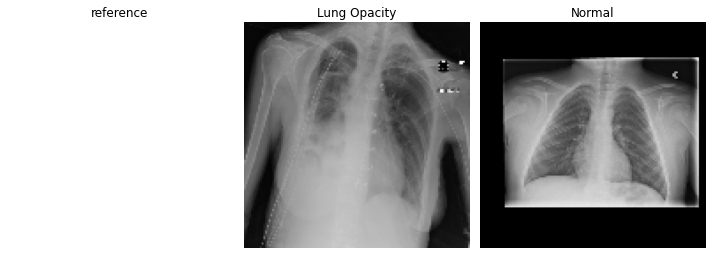

In [ ]:
class_names = ['Lung Opacity','Normal']
# Save an example for each category in a dict
images_dict = dict()
for i, l in enumerate(y_train):
  if len(images_dict)==2:
    break

  l1 = int(l)

  if l1 not in images_dict.keys():
    #a = np.expand_dims(X_train[i], axis=0)
    images_dict[l1] = X_train[i]
    #images_dict[l1] = a
  # Convert to list preserving order of classes
  images_dict_sorted = dict(sorted(images_dict.items()))
  # Sort by key


# Function to plot images
def plot_categories(images1):
  fig, axes = plt.subplots(1, 3, figsize=(10, 8))
  axes = axes.flatten()

  # Plot an empty canvas
  ax = axes[0]
  dummy_array = np.array([[[0, 0, 0, 0]]], dtype='uint8')
  ax.set_title("reference")
  ax.set_axis_off()
  ax.imshow(dummy_array, interpolation='nearest')

  # Plot an image for every category
  for k,v in images1.items():
    ax = axes[k+1]
    #v_img = v.reshape(28,28)
    ax.imshow(v, cmap=plt.cm.binary)
    ax.set_title(f"{class_names[k]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()


# Use the function to plot
plot_categories(images_dict_sorted)

In [ ]:
X_train.shape

(140, 128, 128, 3)

In [ ]:
# Take a random sample of 5000 training images
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

#background = background.reshape(100,128,128,1)

# Use DeepExplainer to explain predictions of the model
e = shap.DeepExplainer(model, background)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [ ]:
# Save only opaque images into the dictionary for checking their SHAP
x_test_opq_dict = dict()
y_test_each_class= dict()
j=0
for i, l in enumerate(y_test):
  if len(x_test_opq_dict)==10:
    break
  l1 = int(l)
  # if l1 not in x_test_dict.keys():
  #   x_test_dict[l1] = X_test[i]
  if l1 == 0: #check if the image is classified as opaque
    x_test_opq_dict[j] = X_test[i]
    y_test_each_class[j] = l1
    j = j+1
# Convert to list preserving order of classes
x_test_each_class = [x_test_opq_dict[i] for i in sorted(x_test_opq_dict)]

# Convert to tensor
x_test_each_class = np.asarray(x_test_each_class)

# Print shape of tensor
print(f"x_test_each_class tensor has shape: {x_test_each_class.shape}")


x_test_each_class tensor has shape: (10, 128, 128, 3)


In [ ]:
y_test_each_class

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}

In [ ]:
# Compute predictions
predictions = model.predict(x_test_each_class)
predicted_class = np.argmax(predictions, axis=1)
predictions

1/1 [==============================] - 0s 19ms/step


array([[1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 2.0884018e-33],
       [1.0000000e+00, 7.3435455e-27],
       [1.0000000e+00, 1.8800342e-31],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 3.4926721e-31],
       [1.0000000e+00, 8.7228580e-30],
       [1.0000000e+00, 3.1056855e-33],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 3.3617781e-32]], dtype=float32)

In [ ]:
predicted_class

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
shap_values = e.shap_values(x_test_each_class,check_additivity=False)

In [ ]:
# plot actual and predicted class
def plot_actual_predicted(images, pred_classes):
  fig, axes = plt.subplots(1, 11, figsize=(16, 15))
  axes = axes.flatten()

  # plot
  ax = axes[0]
  dummy_array = np.array([[[0, 0, 0, 0]]], dtype='uint8')
  ax.set_title("Base reference")
  ax.set_axis_off()
  ax.imshow(dummy_array, interpolation='nearest')
  # plot image
  for k,v in images.items():
    ax = axes[k+1]
    ax.imshow(v, cmap=plt.cm.binary)
    ax.set_title(f"True: %s \nPredict: %s" % (class_names[k], class_names[pred_classes[k]]))
    ax.set_axis_off()
  plt.tight_layout()
  plt.show()

In [ ]:
#plot_actual_predicted(x_test_each_class, predicted_class)

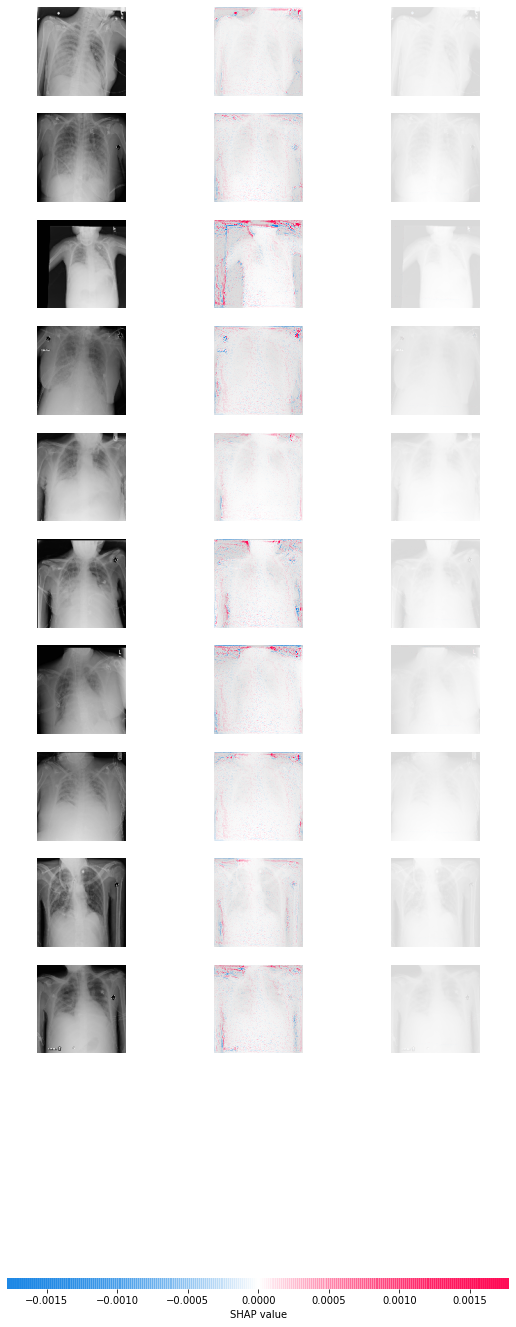

In [ ]:
# Plot reference column
#plot_categories(images_dict)

# Print an empty line to separate the two plots
#print()

# Plot shap values
shap.image_plot(shap_values,x_test_each_class)

In [ ]:
# Download the dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Reshape and normalize data
x_train = x_train.reshape(60000, 28, 28, 1).astype("float32") / 255
x_test = x_test.reshape(10000, 28, 28, 1).astype("float32") / 255

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
y_train[5]

2

In [ ]:
# Define the model architecture using the functional API
inputs = keras.Input(shape=(28, 28, 1))
x = keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = keras.layers.MaxPooling2D((2, 2))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation='relu')(x)
outputs = keras.layers.Dense(10, activation='softmax')(x)

# Create the model with the corresponding inputs and outputs
model = keras.Model(inputs=inputs, outputs=outputs, name="CNN")

# Compile the model
model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=keras.optimizers.Adam(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
  )

# Train it!
model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
1875/1875 [==============================] - 49s 26ms/step - loss: 0.3738 - sparse_categorical_accuracy: 0.8674 - val_loss: 0.3008 - val_sparse_categorical_accuracy: 0.8923
Epoch 2/5
1875/1875 [==============================] - 49s 26ms/step - loss: 0.2491 - sparse_categorical_accuracy: 0.9084 - val_loss: 0.2904 - val_sparse_categorical_accuracy: 0.8958
Epoch 3/5
 217/1875 [==>...........................] - ETA: 40s - loss: 0.1989 - sparse_categorical_accuracy: 0.9290

KeyboardInterrupt: ignored

In [ ]:
for i, l in enumerate(y_train):
  print(l)
  print(i)
  if i == 2:
    break


9
0
0
1
0
2


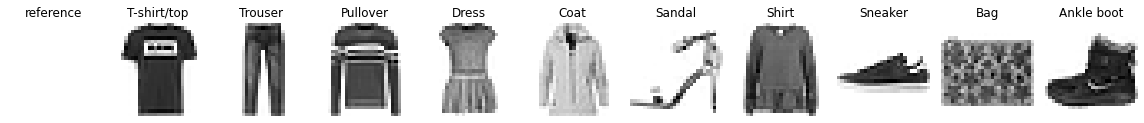

In [ ]:
# Name each one of the classes
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Save an example for each category in a dict
images_dict = dict()
for i, l in enumerate(y_train):
  if len(images_dict)==10:
    break
  if l not in images_dict.keys():
    images_dict[l] = x_train[i].reshape((28, 28))

# Function to plot images
def plot_categories(images):
  fig, axes = plt.subplots(1, 11, figsize=(16, 15))
  axes = axes.flatten()

  # Plot an empty canvas
  ax = axes[0]
  dummy_array = np.array([[[0, 0, 0, 0]]], dtype='uint8')
  ax.set_title("reference")
  ax.set_axis_off()
  ax.imshow(dummy_array, interpolation='nearest')

  # Plot an image for every category
  for k,v in images.items():
    ax = axes[k+1]
    ax.imshow(v, cmap=plt.cm.binary)
    ax.set_title(f"{class_names[k]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()


# Use the function to plot
plot_categories(images_dict)

## DeepExplainer

In [ ]:
# Take a random sample of 5000 training images
background = x_train[np.random.choice(x_train.shape[0], 5000, replace=False)]

# Use DeepExplainer to explain predictions of the model
e = shap.DeepExplainer(model, background)

# Compute shap values
# shap_values = e.shap_values(x_test[1:5])

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [ ]:
# Save an example of each class from the test set
x_test_dict = dict()
for i, l in enumerate(y_test):
  if len(x_test_dict)==10:
    break
  if l not in x_test_dict.keys():
    x_test_dict[l] = x_test[i]

# Convert to list preserving order of classes
x_test_each_class = [x_test_dict[i] for i in sorted(x_test_dict)]

# Convert to tensor
x_test_each_class = np.asarray(x_test_each_class)

# Print shape of tensor
print(f"x_test_each_class tensor has shape: {x_test_each_class.shape}")

x_test_each_class tensor has shape: (10, 28, 28, 1)


In [ ]:
# Compute predictions
predictions = model.predict(x_test_each_class)

# Apply argmax to get predicted class
np.argmax(predictions, axis=1)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Visualizing SHAP

In [ ]:
# Compute shap values using DeepExplainer instance
shap_values = e.shap_values(x_test_each_class)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


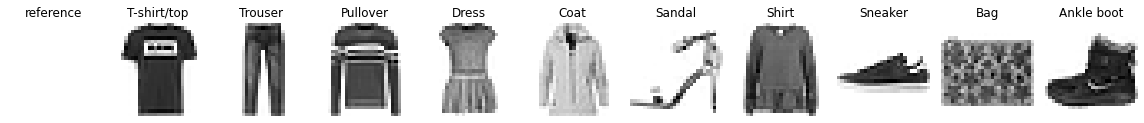

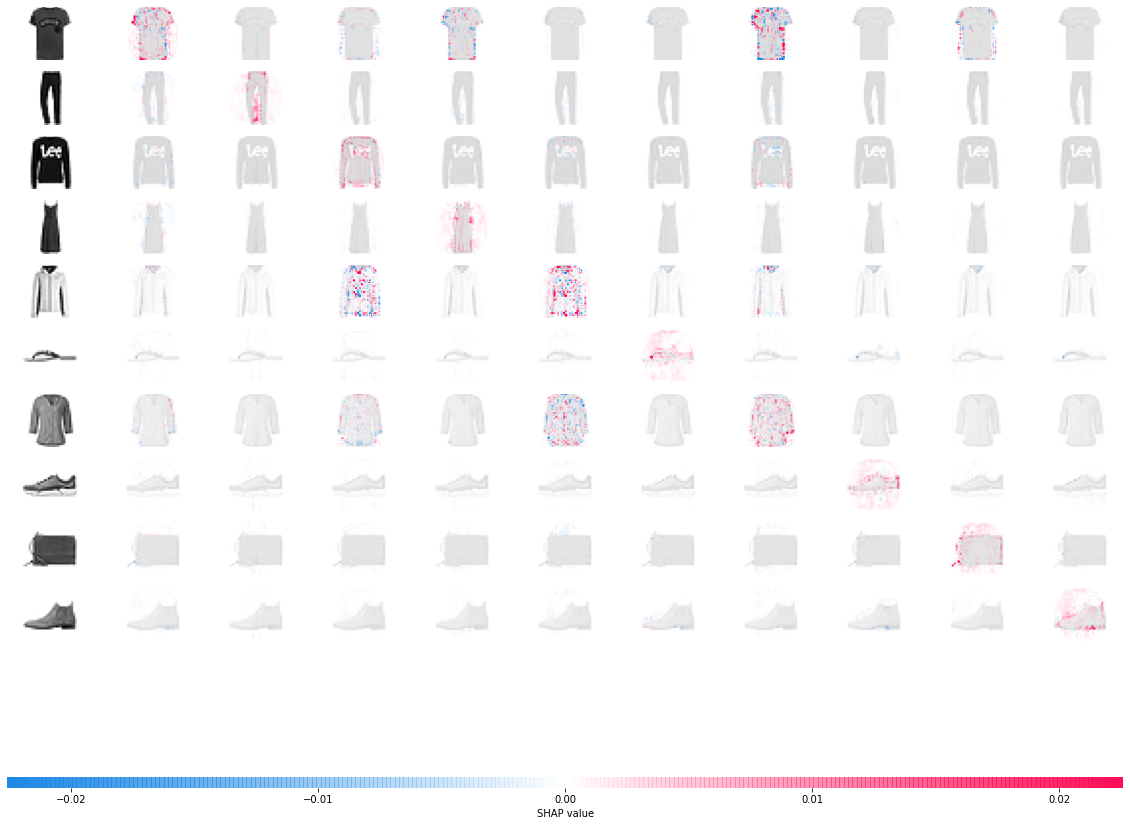

In [ ]:
# Plot reference column
plot_categories(images_dict)

# Print an empty line to separate the two plots
print()

# Plot shap values
shap.image_plot(shap_values, -x_test_each_class)

In [ ]:
# Save the probability of belonging to each class for the fifth element of the set
coat_probs = predictions[4]

# Order the probabilities in ascending order
coat_args = np.argsort(coat_probs)

# Reverse the list and get the top 3 probabilities
top_coat_args = coat_args[::-1][:3]

# Print (ordered) top 3 classes
for i in list(top_coat_args):
  print(class_names[i])

Coat
Pullover
Shirt
